In [2]:
%matplotlib inline

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from astropy.coordinates import Angle
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation, HADec
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
import cmcrameri.cm as cmc
from astropy.io import fits

In [4]:
const_c = c.value   # speed of light [m/s]
frequency = 93.7e9              # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

# Funciones

In [5]:
def long2xyzbroad(coords):
        """
        Returns the nominal ITRF (X, Y, Z) coordinates [m] for a point at
        geodetic latitude and longitude [radians] and elevation [m].
        The ITRF frame used is not the official ITRF, just a right
        handed Cartesian system with X going through 0 latitude and 0 longitude,
        and Z going through the north pole.
        orig. source: http://www.oc.nps.edu/oc2902w/coord/llhxyz.htm
        """

        lat = np.radians(coords[:,0])
        lon = np.radians(coords[:,1])
        elevation = coords[:,2]


        er=6378137.0
        rf=298.257223563

        f=1./rf
        esq=2*f-f**2
        nu=er/np.sqrt(1.-esq*(np.sin(lat))**2)

        x=(nu+elevation)*np.cos(lat)*np.cos(lon)
        y=(nu+elevation)*np.cos(lat)*np.sin(lon)
        z=((1.-esq)*nu+elevation)*np.sin(lat)

        return np.column_stack((x,y,z))

In [6]:
def ecef_to_enu(x, y, z, lat_ref, lon_ref,x_ref,y_ref,z_ref):
    #x_ref, y_ref, z_ref = geodetic_to_ecef(lat_ref, lon_ref, h_ref)

    # Desplazamiento desde el punto de referencia
    dx = x - x_ref
    dy = y - y_ref
    dz = z - z_ref

    lat_ref_rad = np.radians(lat_ref)
    lon_ref_rad = np.radians(lon_ref)

    # Matriz de rotación
    R = [
        [-np.sin(lon_ref_rad), np.cos(lon_ref_rad), 0],
        [-np.sin(lat_ref_rad) * np.cos(lon_ref_rad), -np.sin(lat_ref_rad) * np.sin(lon_ref_rad), np.cos(lat_ref_rad)],
        [np.cos(lat_ref_rad) * np.cos(lon_ref_rad), np.cos(lat_ref_rad) * np.sin(lon_ref_rad), np.sin(lat_ref_rad)]
    ]

    # Transformación
    enu = [
        R[0][0] * dx + R[0][1] * dy + R[0][2] * dz,
        R[1][0] * dx + R[1][1] * dy + R[1][2] * dz,
        R[2][0] * dx + R[2][1] * dy + R[2][2] * dz
    ]

    return enu


In [7]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [8]:
def _earthlocation_to_altaz(location, reference_location):
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [9]:
#función profe
def earth_location_to_local(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    return altaz.cartesian.xyz

In [10]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [11]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return enu_coords

In [12]:
def enu_to_local_altaz(enu_baselines, distance):

    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth

In [13]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

In [14]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [15]:
def h(hObs, gradDec, t_muestreo):

    """ 
    hObs: tiempo de observación, expresado en horas
    gradDec: declinación, expresado en grados
    t_muestre: tiempo de muestreo, expresado en minutos
       """

    observacion_grados = hObs * 15.0
    HA = np.arange(-np.radians(observacion_grados), np.radians(observacion_grados), np.radians((t_muestreo/60)*15))  # [radianes]
    dec = np.radians(gradDec)
    return HA, dec

In [16]:
def grid_sampling(piximg, max_B, coverage):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura

       """
    sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid2 = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda=wavelength #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / (piximg * delta_x)

    u_pixel2 = np.floor(0.5 + coverage[:, 0] / delta_u + piximg / 2).astype(int)
    v_pixel2 = np.floor(0.5 + coverage[:, 1] / delta_u + piximg / 2).astype(int)

    """ for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/delta_u) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/delta_u) + piximg/2)
      uvgrid2[v_pixel, u_pixel] += 1.0 + 1j*0.0 """
      
    np.add.at(uvgrid, (v_pixel2, u_pixel2), 1.0 + 1j*0.0)
    # S(u,v) = 1 otro caso S=0
    """ sampling = np.zeros_like(uvgrid)
    posiciones_con_valores = uvgrid != 0
    sampling[posiciones_con_valores] = 1 """
    sampling[v_pixel2, u_pixel2] = 1.0
    return sampling, uvgrid, uvgrid2


In [11]:
""" def baselines(xyz):
    XYZ_baselines = []                                                                  
    for i in range(len(xyz)):                                                         
        for j in range(i+1,len(xyz)):
            XYZ_baselines.append(np.subtract(xyz[i], xyz[j])) # (u,v)
            XYZ_baselines.append(np.subtract(xyz[j], xyz[i])) # (-u,-v)     

    XYZ_baselines = np.array(XYZ_baselines)
    return XYZ_baselines """

In [17]:
def baselines_enu(enu_coords):
    b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
    b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]
    return b_enu

In [18]:
def b_enu_to_b_equatorial(b_enu, lat_obs):
    """
    b_enu: coordenadas de los baselines en el sistema de referencia plano tangente local (ENU)
    lat_obs: latitud del centro del observatorio, expresado en radianes
    """
    abs_b = np.sqrt(np.sum(b_enu**2, axis=0))

    azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

    x_equatorial = np.cos(lat_obs) * np.sin(elevation) - np.sin(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    y_equatorial = np.cos(elevation) * np.sin(azimuth)
    z_equatorial = np.sin(lat_obs) * np.sin(elevation) + np.cos(lat_obs) * np.cos(elevation) * np.cos(azimuth)

    baseline_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])
    
    return baseline_equatorial

In [19]:
def coverage(baselines, HA, dec, wavelength):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    """
    R_matrix = calc_RR(HA, dec)
    uvw_meters = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_meters[0].reshape(-1), uvw_meters[1].reshape(-1)))/wavelength
    return UV_coverage

In [12]:
""" def new_base(xyz):

    antenna_id = np.arange(0, len(xyz[:,0])) #cantidad de antenas
    antenna_pair_combinations = np.fromiter(itertools.chain(*itertools.combinations(antenna_id, 2)), dtype=int).reshape(-1,2) #combinaciones

    baselines = np.vstack([xyz[antenna_pair_combinations[:,0]] - xyz[antenna_pair_combinations[:,1]], 
                       xyz[antenna_pair_combinations[:,1]] - xyz[antenna_pair_combinations[:,0]]]) # se generan los baselines

    return baselines """

In [74]:
""" def coverage(baselines, HA, dec):
    UV_coverage=[]
    for i in range(len(HA)):
        for j in range(len(baselines)):
            R = calc_R(HA[i],dec)
            UV_coverage.append(np.dot(R, baselines[j]))
    
    UV_coverage = np.array(UV_coverage)
    return UV_coverage """

In [14]:
""" def new_cover(baseline, HA, dec):
    R = calc_RR(HA, dec).transpose(2,0,1)
    coverage = np.dot(R, baseline.T)/wavelength #se divide por la longitud de onda
    return coverage """

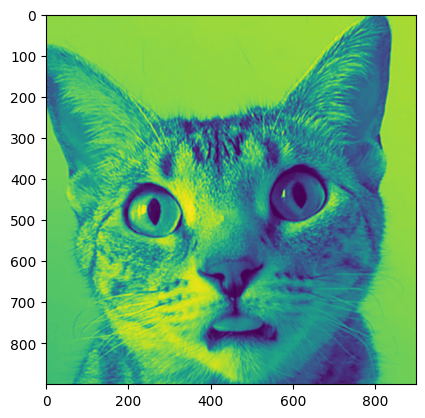

In [20]:
# Cargar la imagen como fuente de luz
image = cv2.imread('cat1.jpg',0)
pix = image.shape[0]
plt.imshow(image)
plt.show()

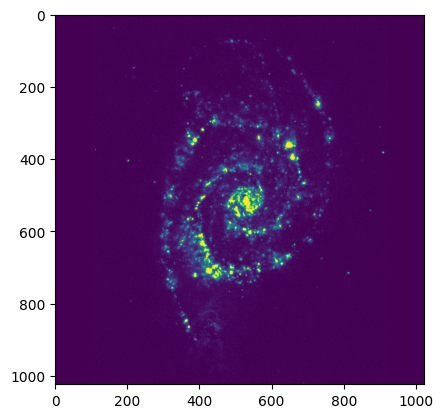

In [45]:
m51ha = fits.open('M51ha.fits')
datos_imagen = m51ha[0].data
m51ha.close()
plt.imshow(datos_imagen)
plt.show()

fft_m51ha = np.fft.fft2(datos_imagen)
ffts_m51ha = np.fft.fftshift(fft_m51ha)
ff = np.abs(np.log(ffts_m51ha))

In [21]:
fft = np.fft.fft2(image)
ffts = np.fft.fftshift(fft)
ff = np.abs(np.log(ffts))

# Ejemplo 1

In [22]:
data = [
    [-41.464183, -72.919694, 100],
    [-41.464507, -72.919898, 100],
    [-41.464263, -72.919739, 100],
    [-41.464304, -72.919764, 100],
    [-41.464342, -72.919789, 100],
    [-41.464387, -72.919819, 100],
    [-41.464424, -72.919843, 100],
    [-41.464469, -72.919870, 100],
]

data = np.array(data)
ref = np.array((-41.463874,-72.920166,100))

In [23]:
local_xyz = EarthLocation.from_geodetic(data[:,1], data[:,0], data[:,2])
reference_location = EarthLocation.from_geodetic(-72.920166, -41.463874,100)

In [24]:
latitude = np.radians(-41.463874)

In [25]:
enu_coords = np.array(earth_location_to_local_enu(local_xyz, reference_location))

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

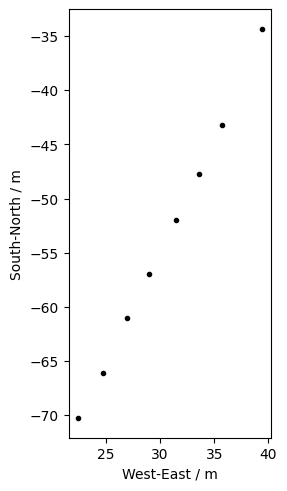

In [26]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [27]:
baseline_enu = baselines_enu(enu_coords)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

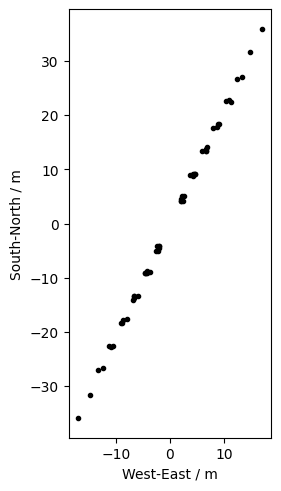

In [28]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(baseline_enu[0], baseline_enu[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [29]:
baseline_equatorial = b_enu_to_b_equatorial(baseline_enu, latitude)

In [30]:
HA, dec = h(6, -23, 6)

In [31]:
cover = coverage(baseline_equatorial, HA, dec, wavelength)

Text(0, 0.5, '$v\\ k\\lambda$')

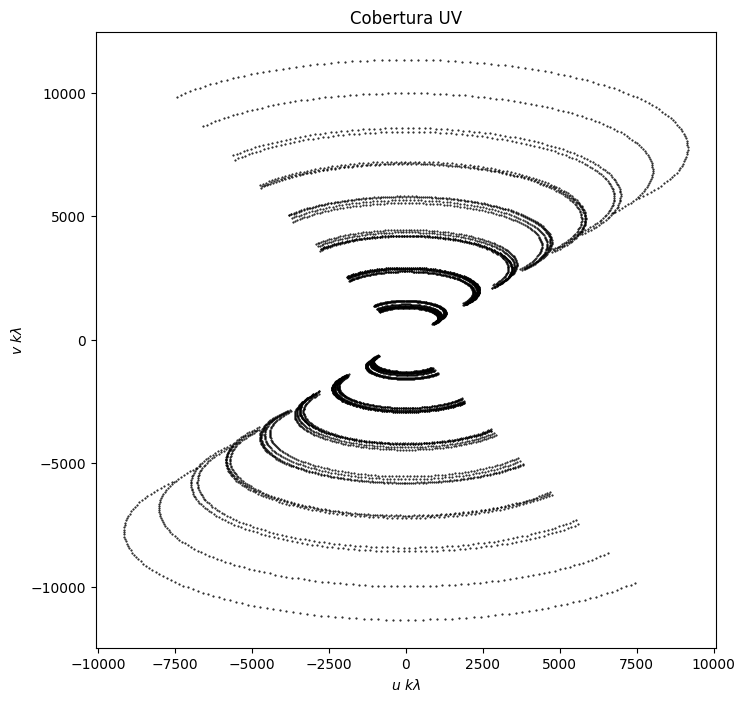

In [32]:
fig = plt.figure(figsize=(8,8))
plt.title("Cobertura UV")
plt.scatter(x=cover[:,0],y=cover[:,1], c="black", marker='.',s=1)
plt.xlabel(r'$u\ k\lambda$')  # Usa 'r' antes de la cadena de texto para que Python la trate como raw string
plt.ylabel(r'$v\ k\lambda$')

In [27]:
""" plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """

' plt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '

In [33]:
new_samplingEJ1, psf, psf3=grid_sampling(pix,np.max(np.abs(baseline_equatorial)), cover)

In [38]:
psf2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(new_samplingEJ1)))
fft_norm = np.max(psf2.real)
psf2/= fft_norm

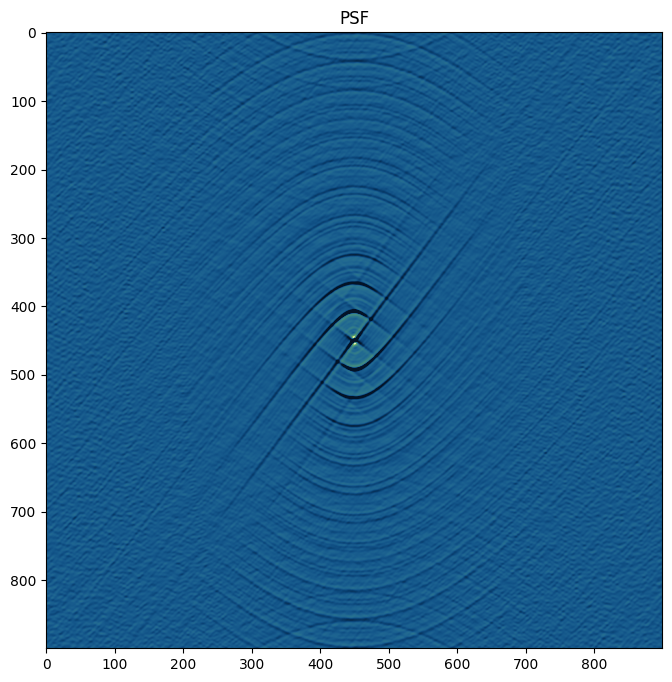

In [39]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf2.real, cmap=cmc.navia_r, vmax=0.1)

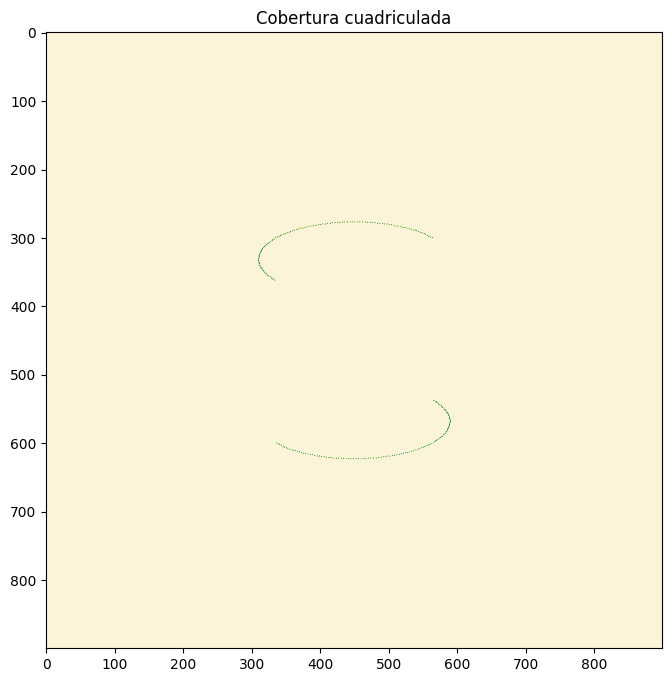

In [197]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('Cobertura cuadriculada')
plt.imshow(new_samplingEJ1.real, cmap=cmc.navia_r)

In [107]:
new_obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ1)))

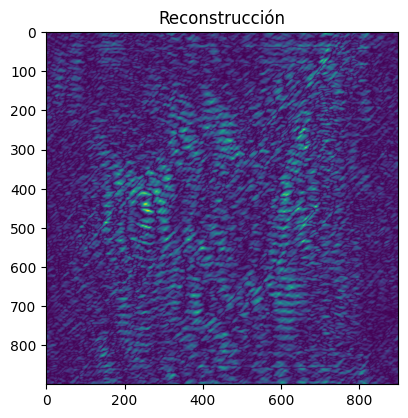

In [108]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.title('Reconstrucción')
plt.imshow(new_obs_EJ1)

# Ejemplo 2

In [109]:
posiciones = [
    (-41.483775, -72.859583, 100),
    (-41.482888, -72.859582, 100),
    (-41.481990, -72.859598, 100),
    (-41.481093, -72.859625, 100),
    (-41.480198, -72.859611, 100),
    (-41.484689, -72.860797, 100),
    (-41.484683, -72.861984, 100),
    (-41.484678, -72.863175, 100),
    (-41.484657, -72.864401, 100),
    (-41.484642, -72.865588, 100),
    (-41.485612, -72.859579, 100),
    (-41.486489, -72.859579, 100),
    (-41.487352, -72.859580, 100),
    (-41.488257, -72.859578, 100),
    (-41.489204, -72.859560, 100),
    (-41.484684, -72.858503, 100),
    (-41.484679, -72.857282, 100),
    (-41.484662, -72.856079, 100),
    (-41.484644, -72.854922, 100),
    (-41.484623, -72.853653, 100)
]
pos2 = np.array(posiciones)
reference = [-41.484687, -72.859583, 100]

In [110]:
local_xyz = EarthLocation.from_geodetic(pos2[:,1], pos2[:,0], pos2[:,2])
reference_location = EarthLocation.from_geodetic(reference[1], reference[0], 100)

In [111]:
enu_coords = np.array(earth_location_to_local_enu(local_xyz, reference_location))

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

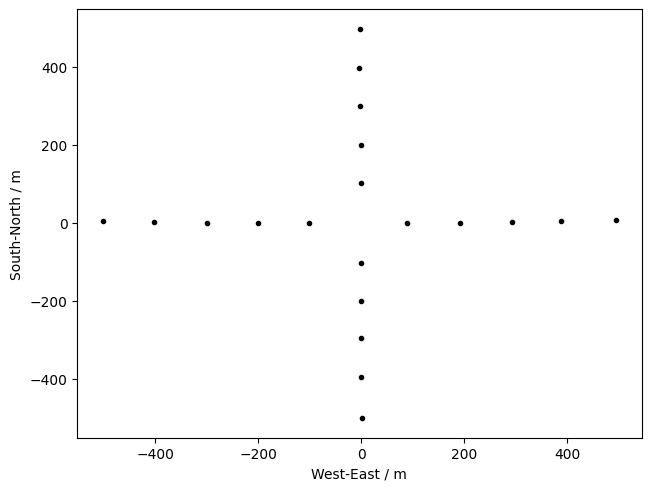

In [112]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [113]:
baseline_enu = baselines_enu(enu_coords)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

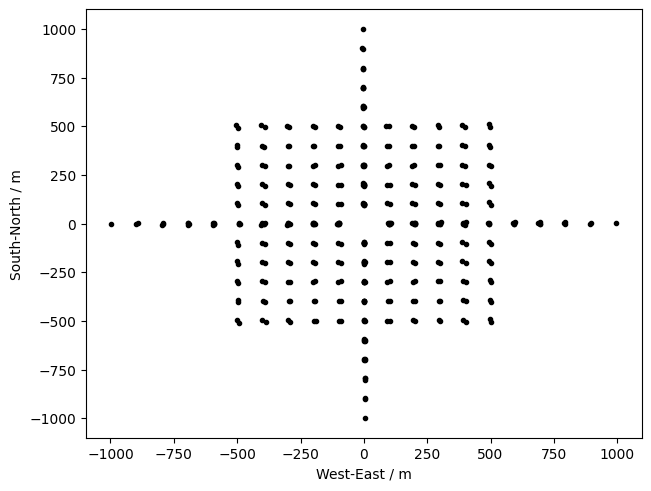

In [114]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(baseline_enu[0], baseline_enu[1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [115]:
baseline_equatorial = b_enu_to_b_equatorial(baseline_enu, latitude)

[  98.51469662  198.25498027  297.89695588  397.28631972  143.47478652
  224.45674509  316.31605526  414.14072692  510.68470006  204.02673984
  301.43070879  397.2797637   497.79376955  602.97531453  135.38251596
  216.82177268  308.78297208  401.06264596  504.13618631   98.51469662
   99.74531273  199.39398669  298.7745936   224.29524926  282.82475851
  359.96213579  447.87048785  538.11135508  302.54123129  399.94526333
  495.79437398  596.3083491   701.48932227  218.88426808  276.52761513
  352.72458686  435.32725483  531.35289385  198.25498027   99.74531273
   99.65079929  199.03137654  316.04837118  359.40310401  422.34767088
  498.653066    580.54690026  402.28061804  499.6840652   595.53260393
  696.04662035  801.22956191  312.87343281  355.82179828  417.67072725
  489.28969763  576.23762081  297.89695588  199.39398669   99.65079929
   99.41001196  411.20991313  444.74501238  496.43378402  561.95932556
  635.13799784  501.91747215  599.31913952  695.16614594  795.67957853
  900.

In [116]:
HA, dec = h(6, -23, 6)

In [117]:
cover = coverage(baseline_equatorial, HA, dec, wavelength)

Text(0, 0.5, 'v (lambda)')

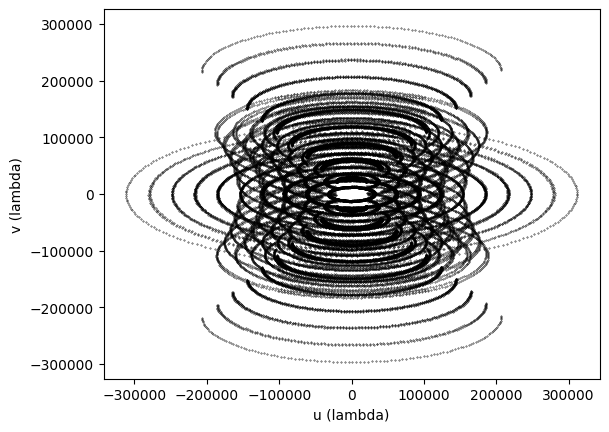

In [118]:
fig, ax = plt.subplots()
ax.scatter(cover[:, 0],cover[:,1], c="black", marker=".", s=0.4)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [119]:
new_samplingEJ2, psf, psf3=grid_sampling(pix,np.max(np.abs(baseline_equatorial)), cover)

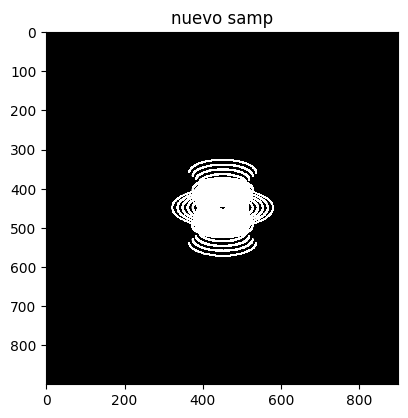

In [120]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ2.real, cmap='gray',vmax=0.0005)

In [121]:
new_obs_EJ2 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ2)))

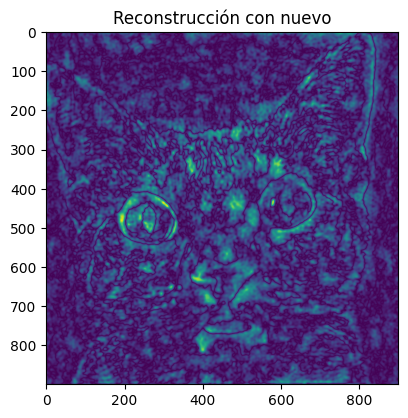

In [122]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ2)

# Ejemplo 3 VLA-D

Formas del UV-Coverage de acuerdo al siguiente PDF pag 84:
https://library.nrao.edu/public/collection/02000000000324.pdf

In [247]:
#posiciones configuración D VLA en coordenadas geograficas (WGS84) - no son exactas
# latitud, longitud, altitud

geoVLA = [[  34.07842625, -107.61828459, 2124.],
       [  34.07808908, -107.61824551, 2124.],
       [  34.07855437, -107.61787752, 2124.],
       [  34.07873509, -107.61831552, 2124.],
       [  34.07850582, -107.61873236, 2124.],
       [  34.07845388, -107.61744277, 2124.],
       [  34.07823558, -107.61685885, 2124.],
       [  34.0779916 , -107.6162074 , 2124.],
       [  34.07762727, -107.61540993, 2124.],
       [  34.07735044, -107.61453944, 2124.],
       [  34.07691797, -107.61358346, 2124.],
       [  34.0765645 , -107.61250526, 2124.],
       [  34.07835685, -107.61913043, 2124.],
       [  34.07807862, -107.61964473, 2124.],
       [  34.07772367, -107.62027238, 2124.],
       [  34.07729173, -107.62099514, 2124.],
       [  34.07685974, -107.62178528, 2124.],
       [  34.07636212, -107.62269102, 2124.],
       [  34.07582174, -107.62364969, 2124.],
       [  34.07930295, -107.61836086, 2124.],
       [  34.07964483, -107.61838996, 2124.],
       [  34.08000375, -107.61844815, 2124.],
       [  34.08055829, -107.61849058, 2124.],
       [  34.08119347, -107.61858118, 2124.],
       [  34.08192272, -107.61862352, 2124.],
       [  34.08272994, -107.61872899, 2124.],
       [  34.08359632, -107.61880064, 2124.]]

geoVLA = np.array(geoVLA)

In [37]:
antenna_config_path = r"C:\Users\matia\Desktop\B\casa-6.5.5-21-py3.8\lib\py\lib\python3.8\site-packages\casadata\__data__\alma\simmos"
antenna_config_file = antenna_config_path + "\\alma.cycle1.1.cfg"
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [38]:
bbbb =np.column_stack((data["x"],data["y"],data["z"]))

In [123]:
base_enu = new_base(bbbb)
D = np.sqrt(np.sum(base_enu, axis=1, keepdims=True)**2)

In [21]:
HA, dec = h(6,-26, 6)

In [22]:
X = np.cos(np.radians(15*3))*D*np.cos(dec)
Y = np.cos(dec)*np.sin(np.radians(15*3))*-D
Z = np.sin(dec)*D

In [23]:
aaaa = np.column_stack((X.reshape(-1),Y.reshape(-1),Z.reshape(-1)))

In [44]:
#localVLA = long2xyzbroad(geoVLA)
abc = EarthLocation.from_geocentric(bbbb[:,0], bbbb[:,1], bbbb[:,2], u.m)
center = EarthLocation.of_site("alma")
x, y, z = earth_location_to_local(abc, center)
coords = np.column_stack((x.value,y.value,z.value))

In [251]:
vla_north = pd.read_csv('VLA_North.csv')
vla_swest = pd.read_csv('VLA_SWest.csv')
vla_seast = pd.read_csv('VLA_SEast.csv')

In [252]:
W = 1e-9*const_c*np.array(vla_swest) #se pasa a metros
E = 1e-9*const_c*np.array(vla_seast)
N = 1e-9*const_c*np.array(vla_north)

In [253]:
eje3=np.vstack((W,N,E))

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

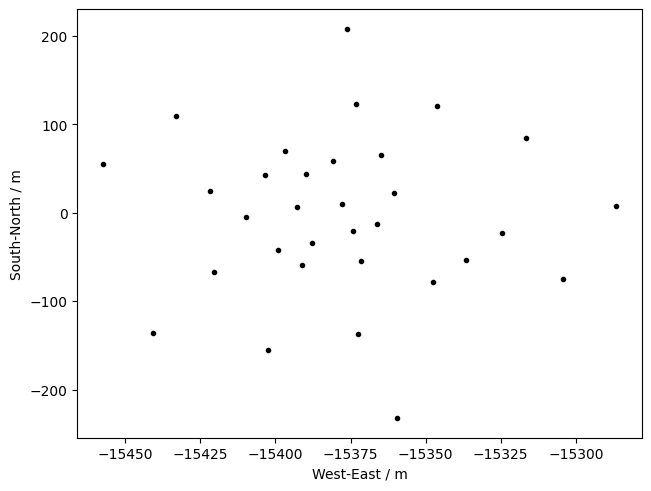

In [45]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(coords[:,0], coords[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [46]:
# 12 horas observacion dec:45
HA, dec = h(1,45, 6)
#UV_coverageEJ3 = coverage(baselines(eje3), HA, dec)/wavelength
#N_UV_coverageEJ3 = new_cover(new_base(base_enu), HA, dec)
N_UV_coverageEJ3N = new_cover(new_base(coords), HA, dec)

Text(0, 0.5, 'v (lambda)')

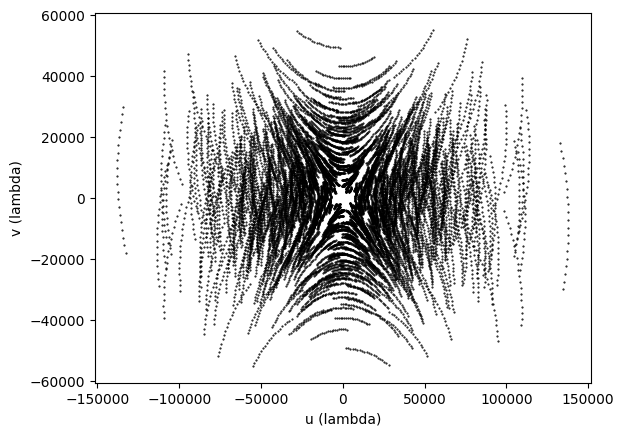

In [47]:
fig, ax = plt.subplots()

ax.scatter(N_UV_coverageEJ3N[:, 0],N_UV_coverageEJ3N[:,1], c="black", marker=".", s=1)
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

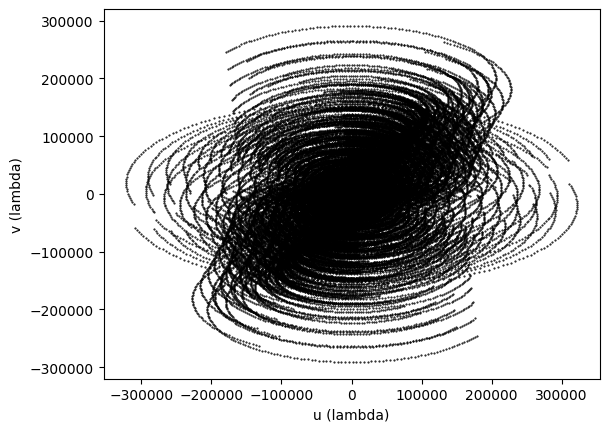

In [250]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ3N[:, 0],N_UV_coverageEJ3N[:,1], c="black", marker=".",s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [101]:
new_samplingEJ3,uvgrid ,_ =grid_sampling(900,np.max(np.abs(new_base(coords))), N_UV_coverageEJ3N)
new_obs_EJ3 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ3)))

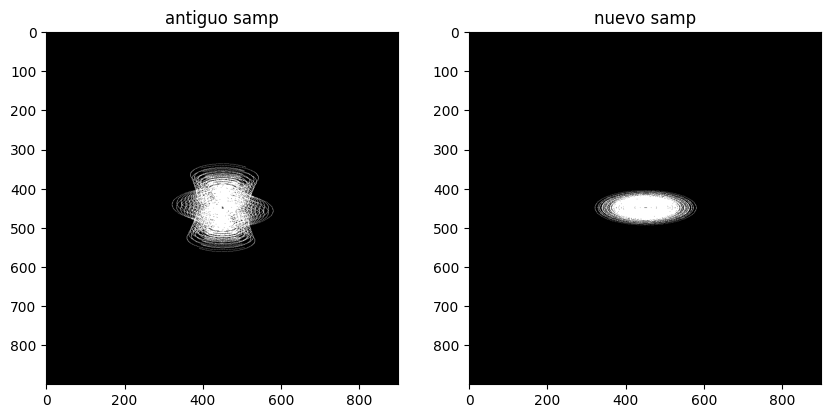

In [102]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ3.real, cmap='gray')

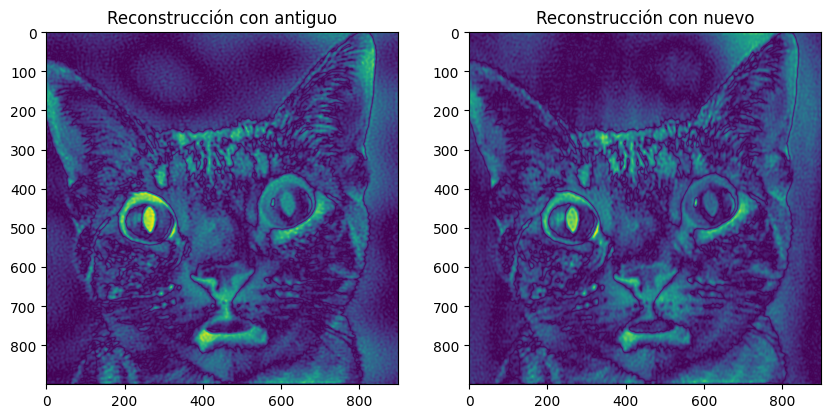

In [97]:
plt.figure(figsize=(10, 10))
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ3)